In [1]:
!python --version

Python 3.10.12


In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.2 MB/s eta 0:00:00


In [3]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.4 MB/s eta 0:00:00


In [4]:
!pip install -q vit-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.1 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision import transforms as T

import transformers

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from torchmetrics import Accuracy
import tqdm

import os
import random
from PIL import Image

from rich import print
from rich.table import Table

## set seed

In [6]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

## Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unrar x '/content/drive/MyDrive/Datasets/covid_dataset_modify.rar' '/content/'

Streaming output truncated to the last 5000 lines.
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/036.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/037.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/038.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/04.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/041.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/042.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/043.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/044.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/045.jpeg      67%  OK 
Extracting  /content/covid_dataset_modify/train/Viral_Pneumonia/046.jpeg      67%

### Calculation of mean and standard deviation of training data

In [ ]:
train_data = torchvision.datasets.ImageFolder('/content/covid_dataset_modify/train',
                                              transform=transforms.Compose([
                                              transforms.Resize(size = (128, 128)),
                                              transforms.ToTensor()]))

train_loader_all = DataLoader(train_data, batch_size=len(train_data), shuffle=True)

def mean_std(loader):
    images, lebels = next(iter(loader))

    # shape of images = [b,c,w,h]
    mean_imgs, std_imgs = images.mean([0,2,3]), images.std([0,2,3])
    return mean_imgs, std_imgs

mean_imgs, std_imgs = mean_std(train_loader_all)
print(f'mean images={mean_imgs}\n std images={std_imgs}')

### transform data

In [24]:
train_transform = transforms.Compose([
                                      transforms.Resize(size = (128, 128)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5085, 0.5086, 0.5086],
                                                           std=[0.2494, 0.2494, 0.2494])])


test_transform = transforms.Compose([
                                     transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5085, 0.5086, 0.5086],
                                                           std=[0.2494, 0.2494, 0.2494])])

In [25]:
train_data = torchvision.datasets.ImageFolder('/content/covid_dataset_modify/train',
                                             transform=train_transform)

valid_data = torchvision.datasets.ImageFolder('/content/covid_dataset_modify/validation',
                                             transform=test_transform)

test_data = torchvision.datasets.ImageFolder('/content/covid_dataset_modify/test',
                                             transform=test_transform)

### DataLoader

In [26]:
set_seed(14)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

valid_loader = DataLoader(valid_data, batch_size=128, shuffle=False)

test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [27]:
x, y = next(iter(train_loader))

In [28]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [29]:
len(train_loader)

313

## EDA

In [ ]:
print(train_data.class_to_idx)

{'Covid': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

In [ ]:
def count_class_img(dataset):
    count_class = {'Covid': 0,
                   'Lung_Opacity': 0,
                   'Normal': 0,
                   'Viral_Pneumonia': 0}

    for i in dataset.imgs:
        if i[1] == 0:
            count_class['Covid'] += 1
        elif i[1] == 1:
            count_class['Lung_Opacity'] += 1
        elif i[1] == 2:
            count_class['Normal'] += 1
        else:
            count_class['Viral_Pneumonia'] += 1

    return count_class

In [ ]:
print(f' Train Data: {count_class_img(train_data)}\n',
      f'Valid Data: {count_class_img(valid_data)}\n',
      f'Test Data: {count_class_img(test_data)}')

Train Data: {'Covid': 4029, 'Lung_Opacity': 4809, 'Normal': 8706, 'Viral_Pneumonia': 2471}
 Valid Data: {'Covid': 503, 'Lung_Opacity': 602, 'Normal': 1130, 'Viral_Pneumonia': 310}
 Test Data: {'Covid': 502, 'Lung_Opacity': 601, 'Normal': 1130, 'Viral_Pneumonia': 310}

### show image

In [ ]:
class_names = train_data.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(18, 12))
    for i, image in enumerate(images):
        plt.subplot(8, 8, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.5085, 0.5086, 0.5086])
        std = np.array([0.2494, 0.2494, 0.2494])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

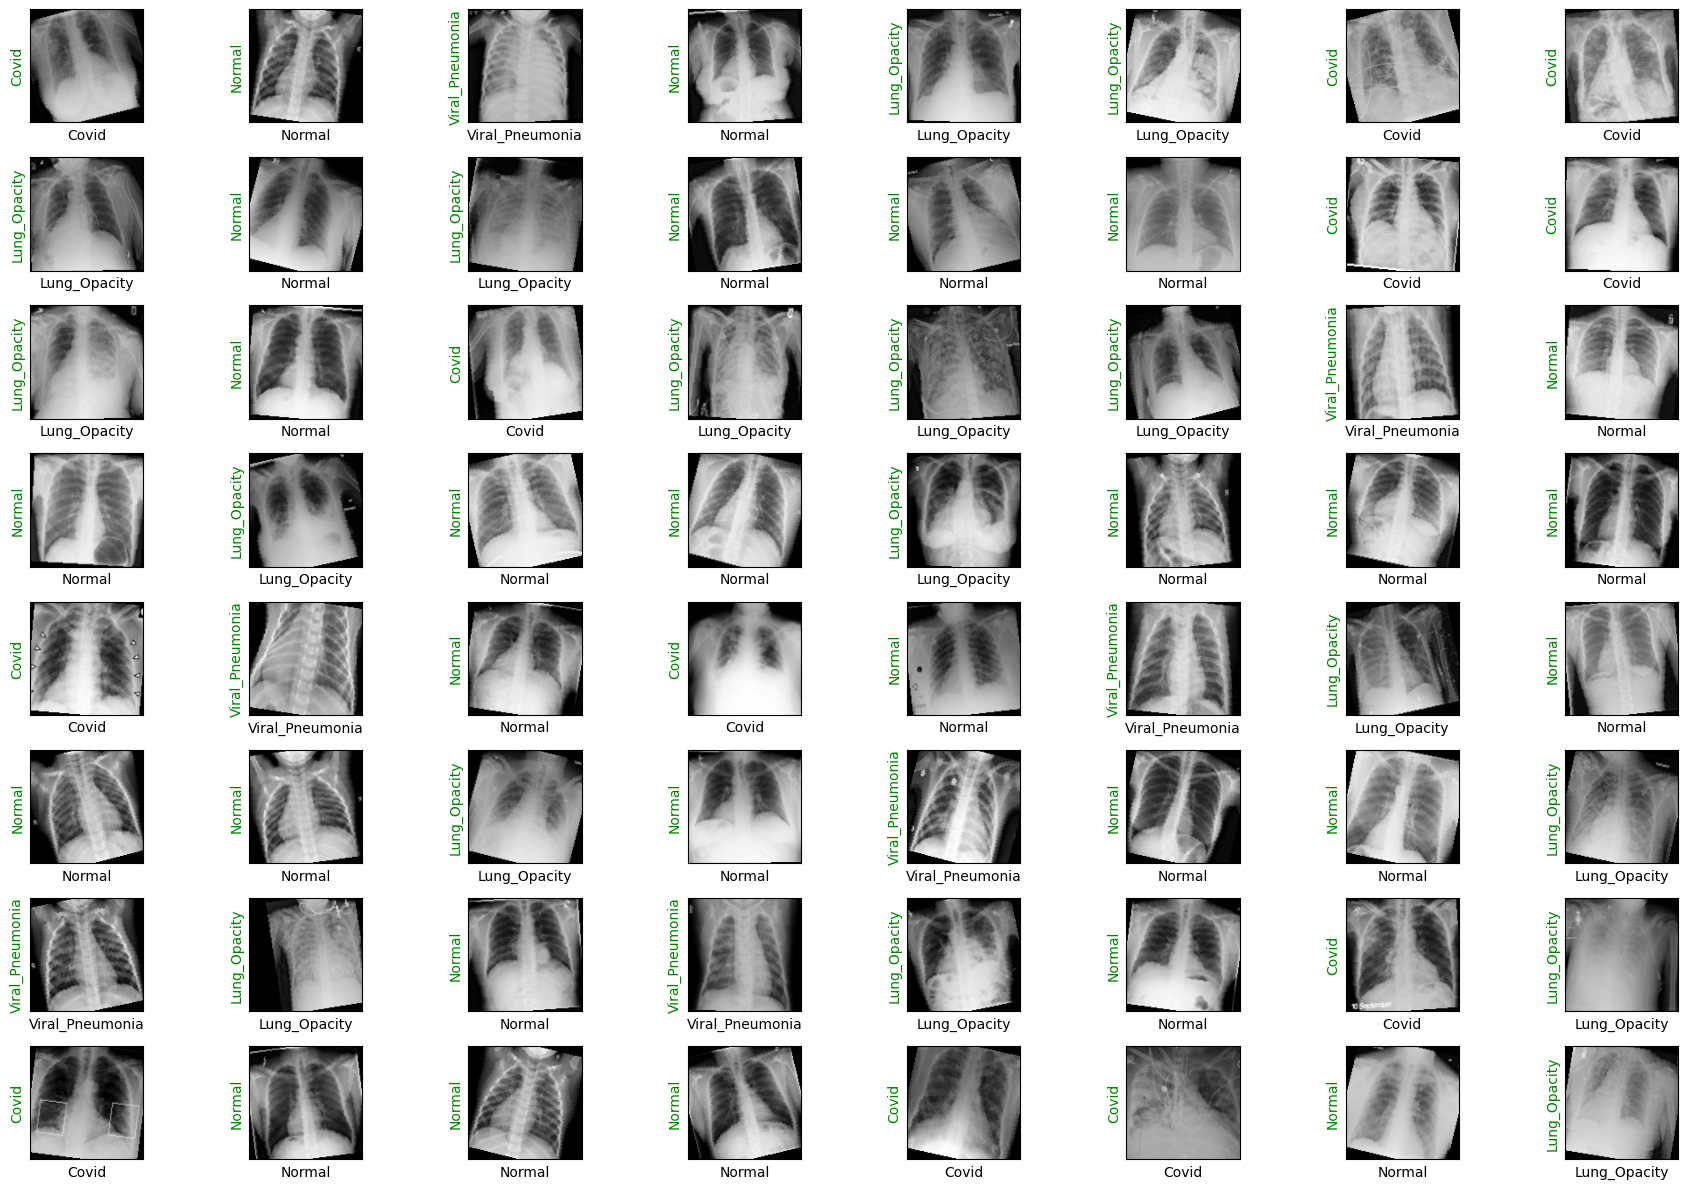

In [ ]:
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

## Device & Utils

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
device

'cuda'

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Model

### CNNTransformer Model

In [ ]:
class CNNTransformerModel(nn.Module):

    def __init__(self, d_model=512, nhead=4, num_encoder_layers=3,
                 num_decoder_layers=0):
        super().__init__()

        # convolution layer
        self.conv1 = self.conv_module(3, 64)
        self.conv2 = self.conv_module(64, 128)
        self.conv3 = self.conv_module(128, 256)
        self.conv4 = self.conv_module(256, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat = nn.Flatten()

        # encoder layer
        self.encoder = nn.Transformer(d_model=d_model, nhead=nhead,
                                      num_encoder_layers=num_encoder_layers,
                                      num_decoder_layers=num_decoder_layers,
                                      batch_first=True).encoder

        #linear
        self.linear = nn.LazyLinear(512)
        self.bn = nn.LazyBatchNorm1d()

        # classifier
        self.fc = nn.LazyLinear(4)

    def forward(self, x):
        out_cnn = self.conv1(x)
        out_cnn = self.conv2(out_cnn)
        out_cnn = self.conv3(out_cnn)
        out_cnn = self.conv4(out_cnn)
        out_cnn = self.flat(self.avgpool(out_cnn))

        y = self.bn(self.linear(out_cnn)).relu()

        y = self.encoder(y)

        y = self.fc(y)

        return y

    def conv_module(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                               nn.BatchNorm2d(out_channels),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))

In [ ]:
model = CNNTransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### CNN Model

In [ ]:
class CnnModel(nn.Module):

    def __init__(self):
        super().__init__()

        # convolution layer
        self.conv1 = self.conv_module(3, 64)
        self.conv2 = self.conv_module(64, 128)
        self.conv3 = self.conv_module(128, 256)
        self.conv4 = self.conv_module(256, 512)

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.flat = nn.Flatten()

        # classifier
        self.fc = nn.LazyLinear(4)

    def forward(self, x):
        out_cnn = self.conv1(x)
        out_cnn = self.conv2(out_cnn)
        out_cnn = self.conv3(out_cnn)
        out_cnn = self.conv4(out_cnn)
        out_cnn = self.flat(self.avgpool(out_cnn))

        y = self.fc(out_cnn)

        return y

    def conv_module(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                               nn.BatchNorm2d(out_channels),
                               nn.ReLU(),
                               nn.MaxPool2d(2, 2))

### Vit with vit_pytorch

In [ ]:
from vit_pytorch import ViT

model_vit_2 = ViT(
    image_size = 128,
    patch_size = 16,
    num_classes = 4,
    dim = 1024,
    depth = 3,
    heads = 4,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)


In [ ]:
model_vit_2(x.to(device)).shape

torch.Size([64, 4])

### EFFICIENTNET_V2_S

In [17]:
def efficientnet_feture_extraction():
    model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1').to(device)
    model.classifier = nn.Linear(in_features=1280, out_features=4)

    model.requires_grad_(False)

    model.classifier.requires_grad_(True)

    return model

In [18]:
def efficientnet_fine_tune():
    model = torchvision.models.efficientnet_v2_s(weights='IMAGENET1K_V1').to(device)
    model.classifier = nn.Linear(in_features=1280, out_features=4)

    return model

In [19]:
model = efficientnet_feture_extraction().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 88.7MB/s]


## Config

In [20]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# metric
metric = Accuracy(task='multiclass', num_classes=4).to(device)

## Train and Evalueation functions

In [21]:
def train_model(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric.reset()

    with tqdm.tqdm(train_loader, unit='batch') as tepoch:
        for inputs, targets in tepoch:
            if epoch:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), n=len(targets))
            metric.update(outputs, targets)

            tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

    return model, loss_train.avg, metric.compute().item()

In [22]:
def evaluate(model, test_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), n=len(targets))

            metric(outputs, targets)

    return loss_eval.avg, metric.compute().item()

## calculate loss

In [ ]:
set_seed(14)

model = CNNTransformerModel().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(1.3695, device='cuda:0')

In [ ]:
set_seed(14)

model = CnnModel().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(1.4293, device='cuda:0')

In [30]:
set_seed(14)

model = efficientnet_feture_extraction().to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(1.3707, device='cuda:0')

In [ ]:
set_seed(14)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model_ef(inputs)
    loss = loss_fn(outputs, targets)

print(loss)

tensor(8.0684, device='cuda:0')

## Find the best learning rate

In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

In [ ]:
set_seed(14)

num_epochs = 5

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f'LR={lr}')

    model = CnnModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model, _, _ = train_model(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

## Find the best learning rate & weight decay

In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

In [ ]:
num_epochs = 5

table = Table(title='Best LR & WD')

table.add_column("Epoch", style="#04C2CE")
table.add_column("Learning Rate", justify="center", style="#B000FD")
table.add_column("Weight Decay", justify="center", style="#DFCE00")
table.add_column("Loss", justify="center", style="#DA1010")


for lr in [0.001, 0.002, 0.003, 0.0004, 0.001, 0.002]:
    for wd in [0., 1e-4, 1e-5]:
        print(f'LR: {lr} - WD: {wd}')
        model = CNNTransformerModel().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd,
                              momentum=0.9)

        for epoch in range(num_epochs):
            model, loss, acc = train_model(model, train_loader, loss_fn,
                                              optimizer, metric, epoch)

            # add row to table
            table.add_row(f'{epoch}', str(lr), str(wd), f'{loss:.2f}', f'{acc:.2f}')

            if epoch == 4:
                table.add_section()
                print('#--------------------------------------------------#')

LR: 0.001 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:25<00:00,  1.55batch/s, loss=0.379, metric=0.859]


#--------------------------------------------------#

LR: 0.001 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=0.39, metric=0.853]


#--------------------------------------------------#

LR: 0.001 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:27<00:00,  1.52batch/s, loss=0.394, metric=0.85]


#--------------------------------------------------#

LR: 0.002 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.53batch/s, loss=0.365, metric=0.862]


#--------------------------------------------------#

LR: 0.002 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:28<00:00,  1.50batch/s, loss=0.37, metric=0.862]


#--------------------------------------------------#

LR: 0.002 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.53batch/s, loss=0.381, metric=0.855]


#--------------------------------------------------#

LR: 0.003 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:29<00:00,  1.49batch/s, loss=0.371, metric=0.862]


#--------------------------------------------------#

LR: 0.003 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=0.365, metric=0.862]


#--------------------------------------------------#

LR: 0.003 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:25<00:00,  1.55batch/s, loss=0.36, metric=0.865]


#--------------------------------------------------#

LR: 0.0004 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:25<00:00,  1.55batch/s, loss=0.416, metric=0.845]


#--------------------------------------------------#

LR: 0.0004 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=0.427, metric=0.84]


#--------------------------------------------------#

LR: 0.0004 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:25<00:00,  1.55batch/s, loss=0.431, metric=0.838]


#--------------------------------------------------#

LR: 0.001 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=0.388, metric=0.853]


#--------------------------------------------------#

LR: 0.001 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:25<00:00,  1.56batch/s, loss=0.392, metric=0.853]


#--------------------------------------------------#

LR: 0.001 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:26<00:00,  1.54batch/s, loss=0.382, metric=0.857]


#--------------------------------------------------#

LR: 0.002 - WD: 0.0

Epoch 4: 100%|██████████| 133/133 [01:24<00:00,  1.58batch/s, loss=0.366, metric=0.862]


#--------------------------------------------------#

LR: 0.002 - WD: 0.0001

Epoch 4: 100%|██████████| 133/133 [01:24<00:00,  1.58batch/s, loss=0.376, metric=0.856]


#--------------------------------------------------#

LR: 0.002 - WD: 1e-05

Epoch 4: 100%|██████████| 133/133 [01:24<00:00,  1.58batch/s, loss=0.37, metric=0.86]


#--------------------------------------------------#

In [ ]:
print(table)

                 Best LR & WD                  
┏━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━┓
┃ Epoch ┃ Learning Rate ┃ Weight Decay ┃ Loss ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━┩
│ 0     │     0.001     │     0.0      │ 0.73 │
│ 1     │     0.001     │     0.0      │ 0.51 │
│ 2     │     0.001     │     0.0      │ 0.45 │
│ 3     │     0.001     │     0.0      │ 0.42 │
│ 4     │     0.001     │     0.0      │ 0.38 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.001     │    0.0001    │ 0.74 │
│ 1     │     0.001     │    0.0001    │ 0.54 │
│ 2     │     0.001     │    0.0001    │ 0.46 │
│ 3     │     0.001     │    0.0001    │ 0.42 │
│ 4     │     0.001     │    0.0001    │ 0.39 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.001     │    1e-05     │ 0.74 │
│ 1     │     0.001     │    1e-05     │ 0.54 │
│ 2     │     0.001     │    1e-05     │ 0.47 │
│ 3     │     0.001     │    1e-05     │ 0.43 │
│ 4     │     0.001     │    1e-05     │ 0.39 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.002     │     0.0      │ 0.70 │
│ 1     │     0.002     │     0.0      │ 0.51 │
│ 2     │     0.002     │     0.0      │ 0.44 │
│ 3     │     0.002     │     0.0      │ 0.40 │
│ 4     │     0.002     │     0.0      │ 0.37 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.002     │    0.0001    │ 0.72 │
│ 1     │     0.002     │    0.0001    │ 0.52 │
│ 2     │     0.002     │    0.0001    │ 0.44 │
│ 3     │     0.002     │    0.0001    │ 0.41 │
│ 4     │     0.002     │    0.0001    │ 0.37 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.002     │    1e-05     │ 0.70 │
│ 1     │     0.002     │    1e-05     │ 0.52 │
│ 2     │     0.002     │    1e-05     │ 0.44 │
│ 3     │     0.002     │    1e-05     │ 0.41 │
│ 4     │     0.002     │    1e-05     │ 0.38 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.003     │     0.0      │ 0.71 │
│ 1     │     0.003     │     0.0      │ 0.49 │
│ 2     │     0.003     │     0.0      │ 0.45 │
│ 3     │     0.003     │     0.0      │ 0.41 │
│ 4     │     0.003     │     0.0      │ 0.37 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.003     │    0.0001    │ 0.70 │
│ 1     │     0.003     │    0.0001    │ 0.51 │
│ 2     │     0.003     │    0.0001    │ 0.43 │
│ 3     │     0.003     │    0.0001    │ 0.40 │
│ 4     │     0.003     │    0.0001    │ 0.37 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │     0.003     │    1e-05     │ 0.70 │
│ 1     │     0.003     │    1e-05     │ 0.49 │
│ 2     │     0.003     │    1e-05     │ 0.44 │
│ 3     │     0.003     │    1e-05     │ 0.38 │
│ 4     │     0.003     │    1e-05     │ 0.36 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │    0.0004     │     0.0      │ 0.80 │
│ 1     │    0.0004     │     0.0      │ 0.59 │
│ 2     │    0.0004     │     0.0      │ 0.49 │
│ 3     │    0.0004     │     0.0      │ 0.45 │
│ 4     │    0.0004     │     0.0      │ 0.42 │
├───────┼───────────────┼──────────────┼──────┤
│ 0     │    0.0004     │    0.0001    

In [ ]:
'''
Best lr & wd is : lr=0.003, wd=1e-5
'''

### Adam

#### best of learning rate

In [ ]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001, 0.0001]:
    print(f'LR={lr}')

    model = CNNTransformerModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr,
                          weight_decay=1e-4)

    for epoch in range(num_epochs):
        model, _, _ = train_model(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

#### best of learning rate & weight decay

In [ ]:
num_epochs = 5

table = Table(title='Best LR & WD')

table.add_column("Epoch", style="#04C2CE")
table.add_column("Learning Rate", justify="center", style="#B000FD")
table.add_column("Weight Decay", justify="center", style="#DFCE00")
table.add_column("Loss", justify="center", style="#DA1010")
table.add_column("Accuracy", justify="center", style="#009900")

for lr in [0.001, 0.002, 0.003, 0.0004, 0.001, 0.002]:
    for wd in [1e-4, 1e-5]:
        print(f'LR: {lr} - WD: {wd}')
        model = CNNTransformerModel().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

        for epoch in range(num_epochs):
            model, loss, acc = train_model(model, train_loader, loss_fn,
                                              optimizer, metric, epoch)

            # add row to table
            table.add_row(f'{epoch}', str(lr), str(wd), f'{loss:.2f}', f'{acc:.2f}')

            if epoch == 4:
                table.add_section()
                print('#--------------------------------------------------#')

## Train & Evaluation model

In [ ]:
# wandb.init(
#       project='covid_detection',
#       name='base_model',
#       config={
#           'learnig_rate': lr,
#           'weight_decay': wd,
#           'batch_size': 64
#       }
#   )

In [31]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

In [52]:
# model = efficientnet_fine_tune().to(device)

# model = torch.load('/content/model--loss_0.15--acc_0.9525.pt').to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

In [53]:
num_epochs = 5

for epoch in range(num_epochs):
    # Train
    model, loss_train, metric_train = train_model(model,train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
    # Validation
    loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)

    if loss_valid < best_loss_valid:
        torch.save(model, f'model--loss_{loss_valid:.2f}--acc_{metric_valid:.4f}.pt')
        best_loss_valid = loss_valid
        print("[italic #1DCC0F]Model Saved!![/italic #1DCC0F]")

    print(f'Valid: Loss = {loss_valid:.4}, Accuracy = {metric_valid:.4}')
    print()

    # wandb.log({"metric_train": metric_train, "loss_train": loss_train,
    #             "metric_valid": metric_valid, "loss_valid": loss_valid})

    epoch_counter += 1

100%|██████████| 313/313 [03:19<00:00,  1.57batch/s, loss=0.075, metric=0.974]


Model Saved!!

Valid: Loss = 0.1438, Accuracy = 0.9591

Epoch 1: 100%|██████████| 313/313 [03:16<00:00,  1.59batch/s, loss=0.0583, metric=0.98]


Valid: Loss = 0.1526, Accuracy = 0.9568

Epoch 2: 100%|██████████| 313/313 [03:13<00:00,  1.62batch/s, loss=0.0496, metric=0.985]


Model Saved!!

Valid: Loss = 0.1391, Accuracy = 0.9599

Epoch 3: 100%|██████████| 313/313 [03:13<00:00,  1.62batch/s, loss=0.0473, metric=0.983]


Valid: Loss = 0.1584, Accuracy = 0.9572

Epoch 4: 100%|██████████| 313/313 [03:12<00:00,  1.62batch/s, loss=0.0432, metric=0.986]


Valid: Loss = 0.1525, Accuracy = 0.9595

In [ ]:
# wandb.finish()

## Plot

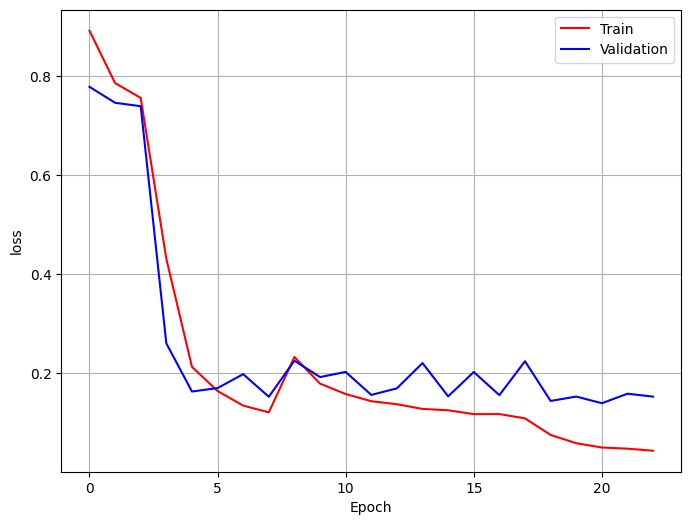

In [54]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

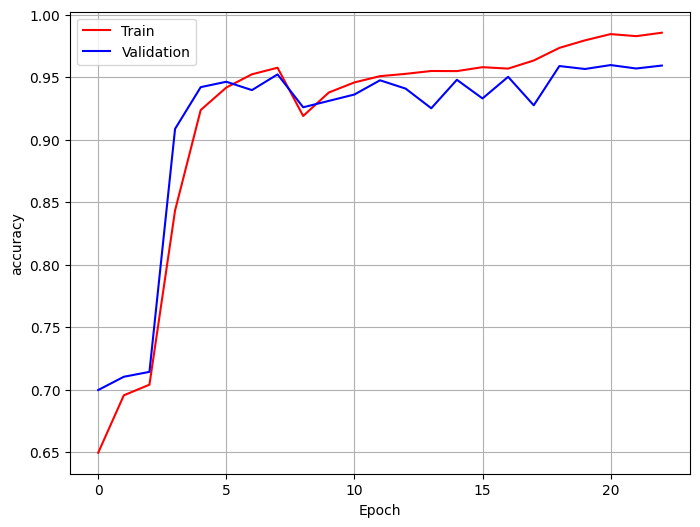

In [55]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

[0.1621067211772691,
 0.16291073949194657,
 0.1608441003912126,
 0.15852445899963735,
 0.154071763224105,
 0.15363637523489715,
 0.15131875049865398,
 0.14596984387784193,
 0.14769397038140952,
 0.14424708098910197,
 0.1487113545663411,
 0.14341320871726115,
 0.14264503859919725,
 0.1410681530219032,
 0.14371382651062808,
 0.14571183217545614,
 0.14356672455824943,
 0.143353410932144,
 0.1454868639376114,
 0.144777689803817,
 0.1424728895407035]

### Evaluate with test data

In [57]:
model_t = torch.load('/content/model--loss_0.14--acc_0.9591.pt').to(device)

In [58]:
num_epochs = 1

for epoch in range(num_epochs):
    # Evaluation
    loss_test, metric_test = evaluate(model_t,
                                     test_loader,
                                     loss_fn,
                                     metric)


    print(f'Test: Loss = {loss_test:.4}, Accuracy = {metric_test:.4}')
    print()

Test: Loss = 0.1683, Accuracy = 0.9457

In [59]:
name_metrics = [metric_train_hist, metric_valid_hist, loss_valid_hist,
                loss_train_hist]

for metrics in name_metrics:
    print(metrics)
    # f = open(f"{metrics}.txt", "a")
    # f.write(str(metrics))
    # f.close()

[
    0.6496127843856812,
    0.6955783367156982,
    0.7040719389915466,
    0.8435173630714417,
    0.9239070415496826,
    0.9419435262680054,
    0.9525355696678162,
    0.9577816724777222,
    0.9191606044769287,
    0.9379465579986572,
    0.9460404515266418,
    0.9510367512702942,
    0.9528853297233582,
    0.9551836252212524,
    0.9550836682319641,
    0.9582313299179077,
    0.957082211971283,
    0.9635773301124573,
    0.9736697673797607,
    0.9797152280807495,
    0.9847114682197571,
    0.9830626845359802,
    0.9858106374740601
]

[
    0.6998035311698914,
    0.7104125618934631,
    0.7143418192863464,
    0.9088408350944519,
    0.9422397017478943,
    0.946561872959137,
    0.9398820996284485,
    0.9524558186531067,
    0.9261296391487122,
    0.9312376976013184,
    0.9363457560539246,
    0.9477406740188599,
    0.9410609006881714,
    0.9253438115119934,
    0.9481335878372192,
    0.9332023859024048,
    0.9504911303520203,
    0.9277013540267944,
    0.9591355323791504,
    0.9567779898643494,
    0.9599214196205139,
    0.9571709036827087,
    0.9595285058021545
]

[
    0.778563915395081,
    0.7463117211647259,
    0.7394031856757953,
    0.26015820931826217,
    0.16283015215033866,
    0.16974168619935076,
    0.19787389040066475,
    0.15220543551158108,
    0.22507236493652602,
    0.19198092266712302,
    0.2023900568781673,
    0.15594795997344207,
    0.16919396720270394,
    0.22032794675154865,
    0.15305988045303198,
    0.20220498064997622,
    0.15548615612397026,
    0.22399008077347912,
    0.14375111051416117,
    0.15263128634725198,
    0.1391448124112426,
    0.1583880642600987,
    0.15249649992245587
]

[
    0.8919461021773553,
    0.7860911739220954,
    0.7560889783633401,
    0.43102159706274035,
    0.21269657094270744,
    0.16376828885721678,
    0.13430994674693694,
    0.12068224609784117,
    0.23248830934688208,
    0.17870080783281986,
    0.15776794047957804,
    0.14320727788170606,
    0.1371291621250121,
    0.12763698546328964,
    0.12488714599576617,
    0.11702710757315413,
    0.11720841370938034,
    0.10853493542331563,
    0.07498837398272543,
    0.05828411515551807,
    0.0496369196349104,
    0.047286986212273806,
    0.04316620430293722
]

In [ ]:
# name_metrics = [metric_train_hist, metric_valid_hist, loss_valid_hist,
#                 loss_train_hist]


f = open("loss_train_hist.txt", "a")
f.write(str(loss_train_hist))
f.close()

'[0.7020734548568726, 0.7955033779144287, 0.828728437423706, 0.8440669775009155, 0.8575068712234497, 0.8659005761146545, 0.8773419857025146, 0.8764926195144653, 0.8148888349533081, 0.8341243863105774, 0.8942793011665344, 0.8988258838653564, 0.9008243680000305, 0.9028728604316711, 0.9061204195022583]'

## number of model parameters

In [ ]:
model = torch.load('/content/model--loss_0.29--acc_0.8974.pt').to(device)

In [50]:
def num_trainable_params(model):
    nums = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return format(nums, ',')

In [51]:
num_trainable_params(model)

'20,182,612'

## Draw Model

In [ ]:
model

CNNTransformerModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=69633b68505abcf44189b7bd36c730677ba6a9a6e148ea392b0168afd71468ab
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


#### torchview

In [ ]:
!pip install torchview

In [ ]:
!pip install torchinfo

In [ ]:
import torchvision
from torchview import draw_graph
import graphviz

graphviz.set_jupyter_format('png')

'svg'

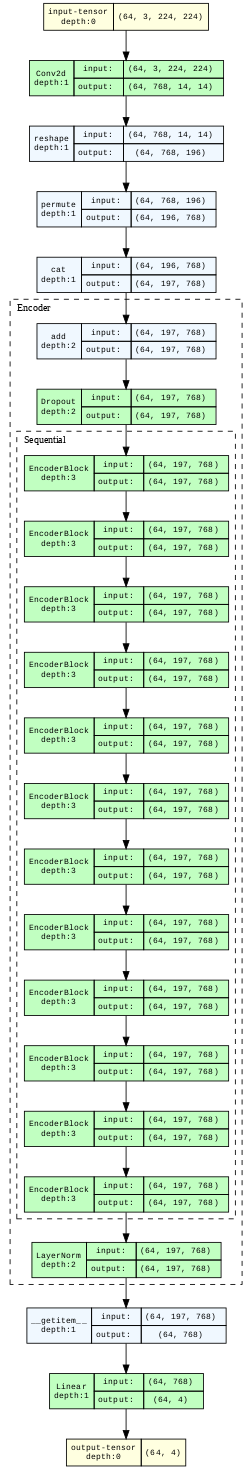

In [ ]:

model_graph = draw_graph(model_vit, input_size=(64,3,224,224), device='meta',
                         expand_nested=True, graph_name='CNNTransformer',
                         roll=True, save_graph=True)
model_graph.visual_graph

In [ ]:
model

CNNTransformerModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

## create requirements file

In [ ]:
!pip install -q pipreqs

In [ ]:
!pipreqs --encoding utf-8 "./"

INFO: Successfully saved requirements file in ./requirements.txt
